<a href="https://colab.research.google.com/github/fbghkh1999/AI/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from keras import layers, models
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import argparse
from IPython.display import clear_output
import os
from tensorflow.keras.utils import plot_model

In [ ]:
# set parameters for model
ARGS_MSE = False
EPOCHS = 20
BATCH_SIZE = 128
recon_loss_func = mse if ARGS_MSE else binary_crossentropy

In [ ]:
# load minist dataset and Normalize pixels
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# sampling function
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# creat vae model
# vae model=encoder+decoder
from keras import layers
def build_vae(input_shape=(original_dim, ), intermediate_dim=512, latent_dim=2):
    # VAE model = encoder + decoder
    # build encoder model
    inputs = layers.Input(shape=input_shape, name='encoder_input')
    x = layers.Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
     # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    
    # build decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = layers.Dense(original_dim, activation='sigmoid', name='decoder_output')(x)
      # instantiate decoder model
    decoder = models.Model(latent_inputs, outputs, name='decoder')
    plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
    
    # we have to reconfigure the model to instrument the output well
    # instantiate VAE model
    rename_tensor = lambda last_tensor, name: layers.Lambda(lambda y: y, name=name)(last_tensor)
    enc_z_mean, enc_z_log_var, enc_z = [rename_tensor(c_lay, c_name) for c_name, c_lay in zip(
        ['enc_z_mean', 'enc_z_log_var', 'enc_z'], encoder(inputs))]
    outputs = decoder(enc_z)
    vae = models.Model(inputs=[inputs], 
                outputs=[outputs, enc_z_mean, enc_z_log_var, enc_z], 
                name='vae_mlp')
    vae.summary()
    def z_log_loss(_, x):
        return K.exp(x)-x
    def z_mean_loss(_, x):
        return K.square(x)
    vae.compile(optimizer='adam',
               loss={'enc_z_mean': z_mean_loss, 'enc_z_log_var': z_log_loss, 'decoder': recon_loss_func},
                loss_weights={'decoder': np.prod(input_shape), 'enc_z_log_var': 0.5, 'enc_z_mean': 0.5},
               metrics={'decoder': 'mae'}
               )
    plot_model(vae,to_file='vae_mlp.png',show_shapes=True)
    
    return encoder, decoder, vae


In [ ]:
# creat train and test bundle to have all information about train and test in bundle
train_bundle = (
    {'encoder_input': x_train},
    {
        'decoder': x_train,
        'enc_z_mean': np.zeros_like(x_train),
        'enc_z_log_var': np.zeros_like(x_train),     
    }
)
valid_bundle = (
    {'encoder_input': x_test},
    {
        'decoder': x_test,
        'enc_z_mean': np.zeros_like(x_test),
        'enc_z_log_var': np.zeros_like(x_test),   
    }
)

In [ ]:
# bulid one vae
encoder, decoder, vae = build_vae()
base_vae_history = vae.fit(
    x=train_bundle[0],
    y=train_bundle[1],
    validation_data=valid_bundle,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
clear_output()

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


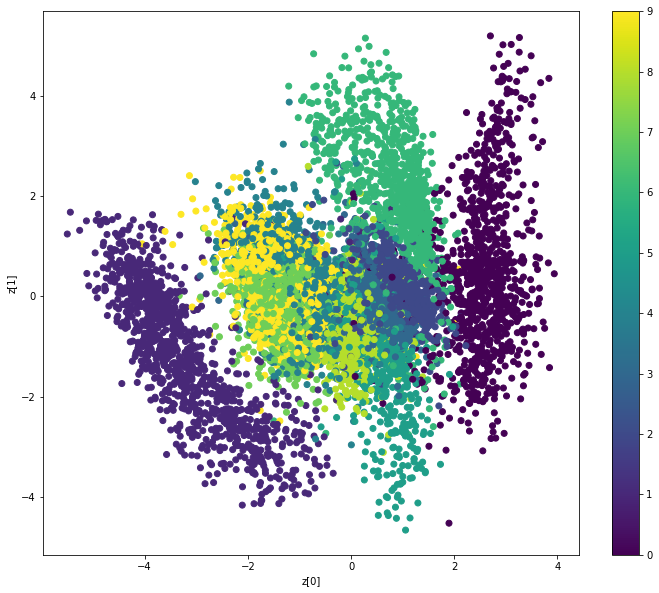

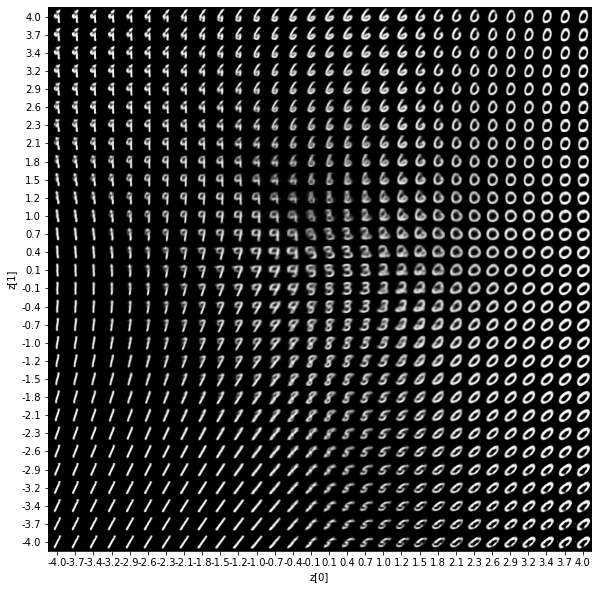

In [ ]:
plot_results((encoder, decoder),
             (x_test, y_test),
             batch_size=BATCH_SIZE,
             model_name="vae_mlp")

In [ ]:
# reduction with pca
# first clear all old session
K.clear_session()

In [ ]:
# creat model again
encoder, decoder, vae = build_vae()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
enc_z (Lambda)                  (None, 2)            0           encoder[0][2]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          403728      enc_z[0][0]                      
____________________________________________________________________________________________

In [ ]:
# use pca dimension reduction
from sklearn.decomposition import PCA
simple_pca = PCA(n_components=2)
x_pca_scores = simple_pca.fit_transform(x_train)
print(x_pca_scores.shape)

(60000, 2)


In [ ]:
# run model again
# encoder
encoder.compile('adam', loss={'z': 'mse'})
encoder.fit(x=x_train,
            y={'z': x_pca_scores},
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
           verbose=False);

In [ ]:
# decoder
decoder.compile('adam', loss={'decoder_output': recon_loss_func})
decoder.fit(x=x_pca_scores,
            y=x_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
           verbose=False);

In [ ]:
pca_pretrained_encoder_history = vae.fit(
    x=train_bundle[0],
    y=train_bundle[1],
    validation_data=valid_bundle,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
clear_output()

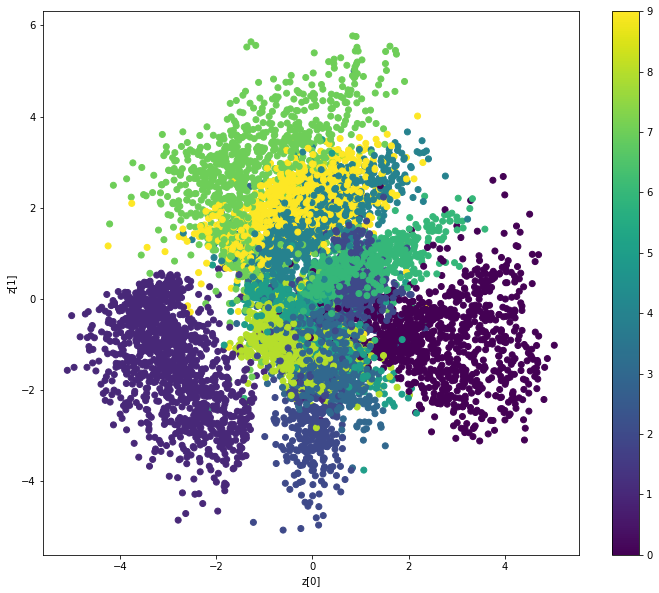

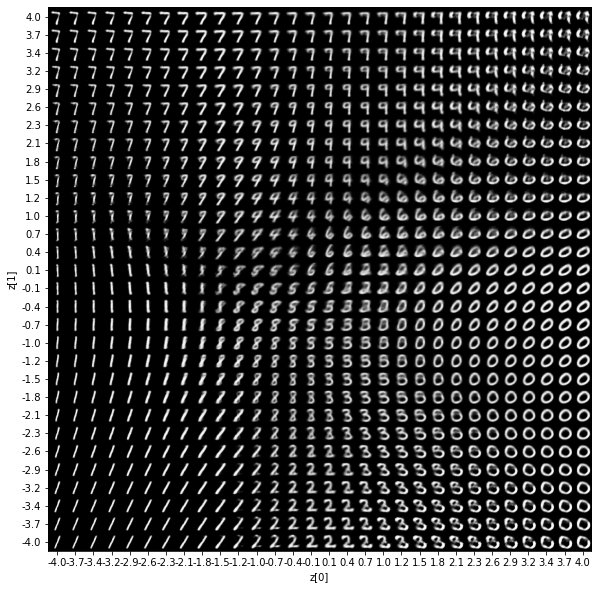

In [ ]:
plot_results((encoder, decoder),
             (x_test, y_test),
             batch_size=BATCH_SIZE,
             model_name="pretrained_vae_mlp")